## Setup

In [81]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [177]:
import itertools

from environment import TrafficModel, Car
from util.network import create_braess_network, create_double_braess_network, create_cars, build_network

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm, trange

In [150]:
def create_generalized_braess_graph(k, *, capacity=1):
    network = nx.DiGraph(
        [('s', f'v{i}') for i in range(1, k + 1)] + 
        [(f'v{i}', f'w{i}') for i in range(1, k + 1)] + 
        [(f'w{i}', 't') for i in range(1, k + 1)] + 
        [(f'v{i}', f'w{i-1}') for i in range(2, k + 1)] + 
        [('s', f'w{k}'), ('v1', 't')]
    )

    nx.set_node_attributes(
        network, {
            's': (0, 0.5),
            'v1': (0.5, 0),
            **{f'v{i}': (0.33, (i - 1) / k) for i in range(2, k + 1)},
            **{f'w{i}': (0.66, i / k) for i in range(1, k)},
            f'w{k}': (0.5, 1),
            't': (1, 0.5)
        }, "position"
    )

    nx.set_edge_attributes(
        network, {
            **{('s', f'v{i}'): (0, i, capacity, 1) for i in range(1, k + 1)},
            **{(f'v{i}', f'w{i}'): (0.01, 0, 1, 1) for i in range(1, k + 1)},  
            **{(f'w{i}', 't'): (0, k - i + 1, capacity, 1) for i in range(1, k + 1)}, 
            **{(f'v{i}', f'w{i-1}'): (1, 0, 1, 1) for i in range(2, k + 1)},
            **{('s', f'w{k}'): (1, 0, 1, 1), ('v1', 't'): (1, 0, 1, 1)}
        }, "latency_params"
    )

    return build_network(network)

In [151]:
def draw_network(network):
    nx.draw(
        network,
        pos=nx.get_node_attributes(network, "position"),
        with_labels=True,
        font_size=8,
        edgelist=[(v, w) for v, w in network.edges if v != w]
    )

In [152]:
def plot_results(car_stats, *, title):
    stats = car_stats.set_index('step')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    pd.DataFrame({route: stats['route'] == route for route in stats['route'].unique()}).expanding().mean().plot(ax=ax1)
    ax1.legend(stats['route'].unique())
    ax1.set_title('Fraction of cars per route')

    pd.DataFrame({'Travel time': stats['travel_time'], 'Total cost': stats['total_cost']}).expanding().mean().plot(ax=ax2)
    ax2.set_title('Social welfare')

    fig.suptitle(title)

## Sanity check: Show generalized Braess graph

In [153]:
network = create_generalized_braess_graph(1)

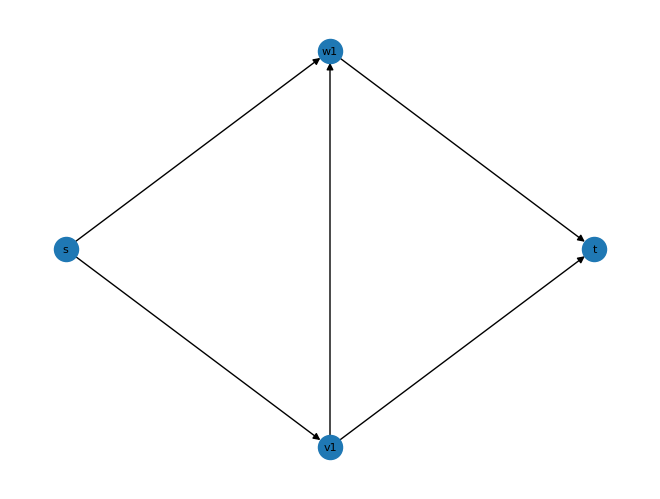

In [155]:
draw_network(network)

## Individual scenarios

### Unrestricted

In [173]:
k = 2
number_of_steps = 1000
car_counts = {('s', 't'): 30}

network = create_generalized_braess_graph(k, capacity=13)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))
step_stats, car_stats = model.run_sequentially(number_of_steps, show_progress=False)

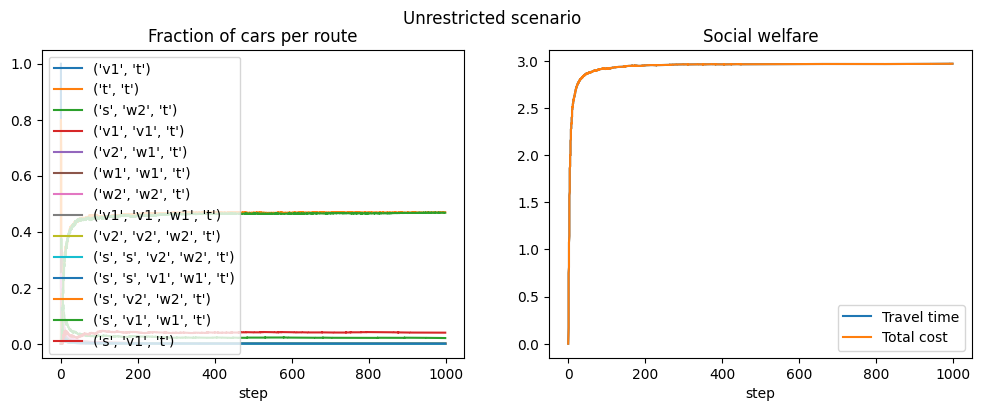

In [174]:
plot_results(car_stats, title='Unrestricted scenario')

### Restricted

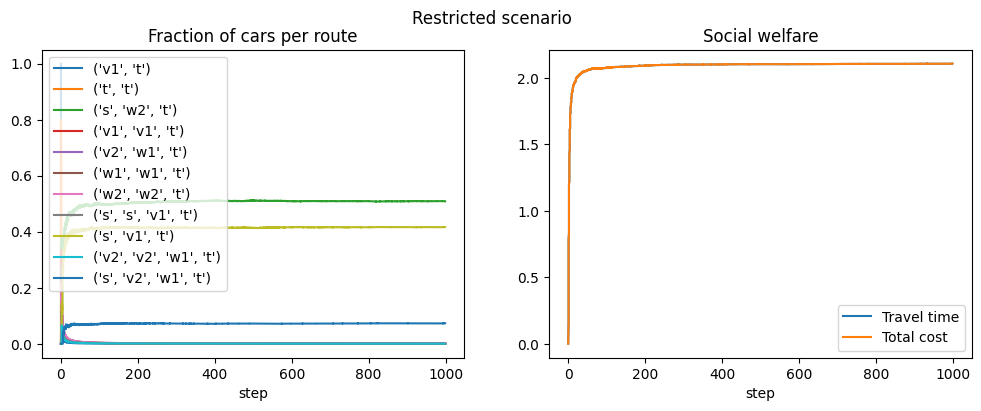

In [175]:
k = 2
number_of_steps = 1000
car_counts = {('s', 't'): 30}

network = create_generalized_braess_graph(k, capacity=13)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))

# Close all edges of type A
for i in range(1, k + 1):
    model.set_edge_restriction((f'v{i}', f'w{i}'), False)

step_stats, car_stats = model.run_sequentially(number_of_steps, show_progress=False)

plot_results(car_stats, title='Restricted scenario')

## Comparison of unrestricted and restricted

In [159]:
k = 2
number_of_steps = 2_000
car_counts = {('s', 't'): 30}
capacity = 13

In [160]:
# Unrestricted
network = create_generalized_braess_graph(k, capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))
_, car_stats_unrestricted = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Unrestricted mean travel time: {(-car_stats_unrestricted["travel_time"]).mean()}')

# Restricted
network = create_generalized_braess_graph(k, capacity=capacity)
model = TrafficModel(network, create_cars(network, car_counts=car_counts))

# Close all edges of type A
for i in range(1, k + 1):
    model.set_edge_restriction((f'v{i}', f'w{i}'), False)

_, car_stats_restricted = model.run_sequentially(number_of_steps, show_progress=False)
print(f'Restricted mean travel time: {(-car_stats_restricted["travel_time"]).mean()}')

Unrestricted mean travel time: -2.968794888305513
Restricted mean travel time: -2.107201855822291


Text(0.5, 0.98, 'Travel time')

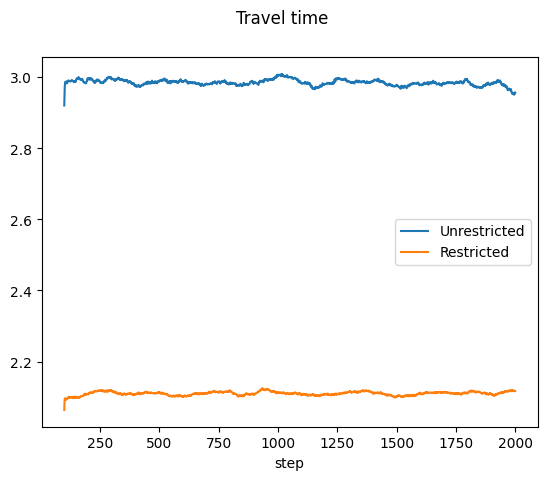

In [167]:
fig, ax = plt.subplots(1, 1)

pd.DataFrame({
    'Unrestricted': car_stats_unrestricted.groupby('step')['travel_time'].mean(), 
    'Restricted': car_stats_restricted.groupby('step')['travel_time'].mean()}).rolling(100).mean().plot(ax=ax, xlabel='step')

fig.suptitle("Travel time")

## Find optimal capacity

100%|██████████| 19/19 [01:24<00:00,  4.46s/it]


Best improvement found with capacity: 20


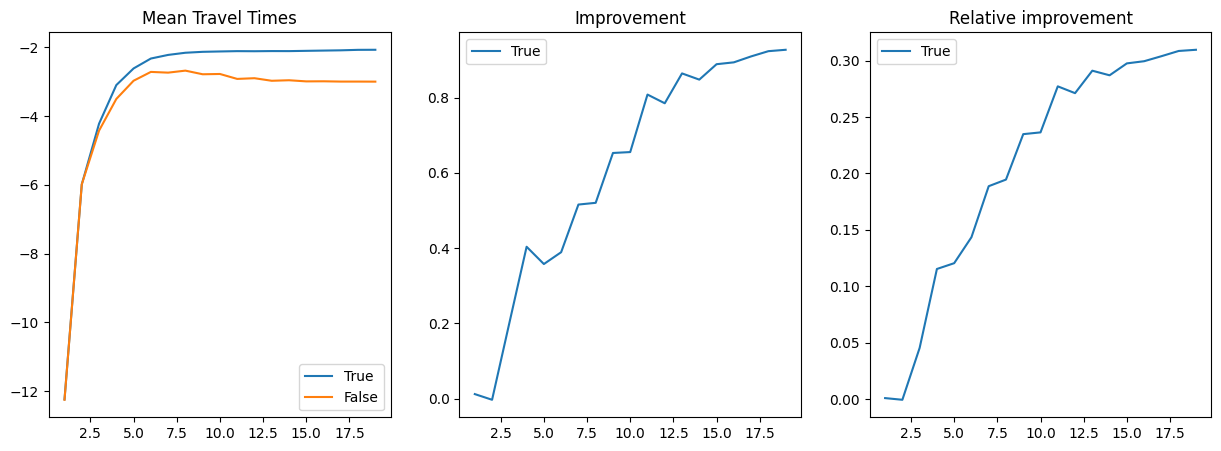

In [180]:
k = 2
number_of_steps = 1_000
car_counts = {('s', 't'): 30}

capacities = list(range(1, 20))

mean_travel_times = []
for capacity in tqdm(capacities):
    mean_travel_times.append({})
    for restricted in [True, False]:
        network = create_generalized_braess_graph(k, capacity=capacity)
        model = TrafficModel(network, create_cars(network, car_counts=car_counts))
        
        if restricted:
            # Close all edges of type A
            for i in range(1, k + 1):
                model.set_edge_restriction((f'v{i}', f'w{i}'), False)

        step_stats, car_stats = model.run_sequentially(number_of_steps, show_progress=False)

        mean_travel_times[-1][restricted] = (-car_stats["travel_time"]).mean()

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

mean_travel_times = pd.DataFrame(mean_travel_times)

ax1.plot(capacities, mean_travel_times)
ax1.legend(mean_travel_times.columns)
ax1.set_title('Mean Travel Times')

improvement = mean_travel_times.drop([False], axis=1).sub(mean_travel_times[False], axis=0)
ax2.plot(capacities, improvement)
ax2.legend(improvement.columns)
ax2.set_title('Improvement')

relative_improvement = improvement.div(mean_travel_times[False].abs(), axis=0)
ax3.plot(capacities, relative_improvement)
ax3.legend(relative_improvement.columns)
ax3.set_title('Relative improvement')

print(f'Best improvement found with capacity: {np.argmax(improvement.max(axis=1)) + 2}')